In [11]:
from collections import OrderedDict
from itertools import product
import random

import os
from importlib import reload

import pandas as pd
import xgboost as xgb
import numpy as np
#import performance_metrics

In [26]:
# read h5 file from data folder
x_train = pd.read_hdf('Insight-Project/data/x_train.h5')
y_train = pd.read_hdf('Insight-Project/data/y_train.h5')
x_val = pd.read_hdf('Insight-Project/data/x_val.h5') 
y_val = pd.read_hdf('Insight-Project/data/y_val.h5')
x_test = pd.read_hdf('Insight-Project/data/x_test.h5')
y_test = pd.read_hdf('Insight-Project/data/y_test.h5')
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)
#(31776, 174) (31776,) (7944, 174) (7944,) (9930, 174) (9930,)

(31776, 174) (31776,) (7944, 174) (7944,) (9930, 174) (9930,)


In [27]:
ratio = (y_train == 0).sum()/ (y_train == 1).sum()
print("ratio of 0 to 1 in target column ", ratio)
print("Postive examples in train set: {}".format(np.sum(y_train==0)))
print("Negative examples in train set: {}".format(np.sum(y_train==1)))

print("Postive examples in test set: {}".format(np.sum(y_test==0)))
print("Negative examples in test set: {}".format(np.sum(y_test==1)))

ratio of 0 to 1 in target column  1.0007555723460522
Postive examples in train set: 15894
Negative examples in train set: 15882
Postive examples in test set: 4991
Negative examples in test set: 4939


In [29]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import  metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
import time

"""
import xgboost as xgbd

#Loading data into DMatrices
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
"""


def modelfit(alg, x_train, y_train,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    start_time = time.time()
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(x_train, label=y_train)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
        print("cvresult.shape[0] :",cvresult.shape[0] )
        #clf.best_ntree_limit
    
    #Fit the algorithm on the data
    alg.fit(x_train, y_train,eval_metric='auc')
    #print("best ntree limit: ", alg.best_ntree_limit)
    print ('Model trained in seconds ',format(time.time() - start_time))   
    #Predict training set:
    dtrain_predictions = alg.predict(x_train)
    dtrain_predprob = alg.predict_proba(x_train)[:,1]
        
    #Print model report:
    print ("Accuracy : " , metrics.accuracy_score(y_train, dtrain_predictions))
    print ("AUC Score (Train):", metrics.roc_auc_score(y_train, dtrain_predprob))
    

    feat_imp = pd.Series(alg.get_booster().get_score(importance_type='weight')).sort_values(ascending=False)[:20]
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    return alg


cvresult.shape[0] : 146
Model trained in seconds  71.62596988677979
Accuracy :  0.7174282477341389
AUC Score (Train): 0.795481291281094


"\nbase_score=0.5, booster='gbtree', colsample_bylevel=1,\n       colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,\n       importance_type='gain', interaction_constraints='',\n       learning_rate=0.300000012, max_delta_step=0, max_depth=6,\n       min_child_weight=1, missing=nan, monotone_constraints='()',\n       n_estimators=26, n_jobs=0, num_parallel_tree=1,\n       objective='binary:logistic', random_state=0, reg_alpha=0,\n       reg_lambda=1, scale_pos_weight=11.329374028968076, subsample=0.5,\n       tree_method='exact', validate_parameters=1, verbosity=None)\n"

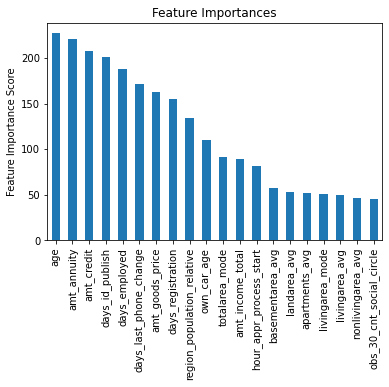

In [30]:
#clf = XGBClassifier(n_estimators=1000, objective='binary:logistic', gamma=0.1, subsample=0.5, scale_pos_weight=ratio )

#Choose all predictors except target & IDcols
xgb_model = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
xgb_clf = modelfit(xgb_model, x_train, y_train)

"""
base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.300000012, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=nan, monotone_constraints='()',
       n_estimators=26, n_jobs=0, num_parallel_tree=1,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=11.329374028968076, subsample=0.5,
       tree_method='exact', validate_parameters=1, verbosity=None)
"""

In [31]:
xgb_clf.get_xgb_params()

{'objective': 'binary:logistic',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.8,
 'gamma': 0,
 'gpu_id': -1,
 'interaction_constraints': '',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 1,
 'monotone_constraints': '()',
 'n_jobs': 4,
 'num_parallel_tree': 1,
 'random_state': 27,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 0.8,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'nthread': 4,
 'seed': 27}

In [38]:
y_val.dtypes

dtype('int64')

In [47]:
# predicting on val dataset
val_predicted_labels = xgb_clf.predict(x_val)
val_predicted_proba = xgb_clf.predict_proba(x_val)[:,1]


In [51]:
np.unique(y_val)

array([0, 1])

In [65]:
#Predict on validation set
import sys
sys.path.append( "Insight-Project/model/")
from performance_metrics import * 

In [66]:
from sklearn import metrics
print(metrics.classification_report(y_val, val_predicted_labels, labels=[1,0]))

              precision    recall  f1-score   support

           1       0.64      0.62      0.63      4004
           0       0.63      0.64      0.63      3940

    accuracy                           0.63      7944
   macro avg       0.63      0.63      0.63      7944
weighted avg       0.63      0.63      0.63      7944



In [68]:

def get_metrics(true_labels, predicted_labels):
    accuracy = np.round(metrics.accuracy_score(true_labels, predicted_labels), 4)
    prec = np.round(metrics.precision_score(true_labels, predicted_labels, average='weighted'), 4)
    recall = np.round(metrics.recall_score(true_labels, predicted_labels, average='weighted'), 4)
    f1 = np.round( metrics.f1_score(true_labels, predicted_labels, average='weighted'), 4)

    df = pd.DataFrame([[accuracy, prec, recall, f1]], index=['performance'], columns=["accuracy", "precision", "recall", "f1_score"])
    print(df)
    return df


# get AUC score for both train and test data sets

def roc_auc_scorer( y, y_pred ) :
    roc_score = metrics.roc_auc_score( y, y_pred )
    print("roc_score ",roc_score)
    lr_fpr, lr_tpr, _ = roc_curve(y, y_pred)
    
    # plot the roc curve for the model
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label='XGBoost')
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

Model Performance metrics:
------------------------------
             accuracy  precision  recall  f1_score
performance    0.6315     0.6317  0.6315    0.6315

ROC plot
roc_score  0.6904747853669174


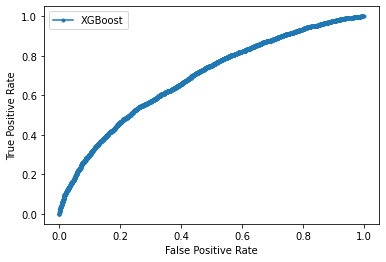

In [69]:
print('Model Performance metrics:')
print('-' * 30)
get_metrics(y_val, val_predicted_labels)
    
print('\nROC plot')
roc_auc_scorer(y_val, val_predicted_proba)

